In [1]:
from matplotlib import pyplot as plt
import torch
import torch.functional as F
import biosupcon as tools
import albumentations as A
import albumentations.pytorch as AT
import pandas as pd
scaler = torch.cuda.amp.GradScaler()

/home/agporto/miniconda3/envs/soup/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
ckpt_pretrained = './weights/effnetb4_damselfly_stage1/swa'
data_dir = '/home/agporto/Dropbox/Year_2023/morph_moritz_aligned/dataset2/'
valid_transforms = A.Compose([A.Resize(512, 512), A.Normalize(), AT.ToTensorV2()])

transform_dict = {
            "train_transforms": valid_transforms,
            'valid_transforms': valid_transforms}

num_classes = 4
batch_sizes = {
    "train_batch_size": 25,
    'valid_batch_size': 25
}
num_workers = 16
backbone = 'timm_tf_efficientnet_b4'
stage = 'first'

loaders = tools.utils.build_loaders(data_dir, transform_dict, batch_sizes, num_workers, second_stage=(stage == 'second'))
    

In [12]:
model = tools.utils.build_model(backbone, second_stage=(stage == 'second'), num_classes=num_classes, ckpt_pretrained=ckpt_pretrained).cuda()
model.use_projection_head(False)
model.eval()

embeddings_train, labels_train = tools.utils.compute_embeddings(loaders['valid_loader'], model, scaler)
paths_train = [item[0] for item in loaders['valid_loader'].dataset.imgs]
reduced_data, colnames, _ = tools.vis.embbedings_dimension_reductions(embeddings_train)

vis_x_train = reduced_data[:,2]
vis_y_train = reduced_data[:,3]

df = pd.DataFrame(reduced_data, columns=colnames)
df['paths'] = paths_train
df['class'] = labels_train
df['class_str']=[item[0].split('/')[-2] for item in loaders['valid_loader'].dataset.imgs]



tf_efficientnet_b4


/home/agporto/miniconda3/envs/soup/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/agporto/miniconda3/envs/soup/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [13]:
tools.vis.bokeh_plot(df)

In [14]:

# import required libraries
import numpy as np
from numpy.linalg import norm
cosine = np.dot(embeddings_train,embeddings_train.T)


In [ ]:

pd.DataFrame(cosine).to_csv('cosine.csv')

In [15]:
import cv2
import numpy as np
img_path = '/home/agporto/Dropbox/Year_2023/morph_moritz_aligned/dataset/val/androchrome/2016_07_08_time_13_23_34_333000_roi_03.jpg'
model = tools.utils.build_model(backbone, second_stage=(stage == 'second'), num_classes=num_classes, ckpt_pretrained=ckpt_pretrained).cuda()


tf_efficientnet_b4


In [16]:
img = cv2.imread( img_path, 1)
img = cv2.resize(img,(1024,1024))
img = np.float32(img) / 255
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = tools.vis.preprocess_image(img)

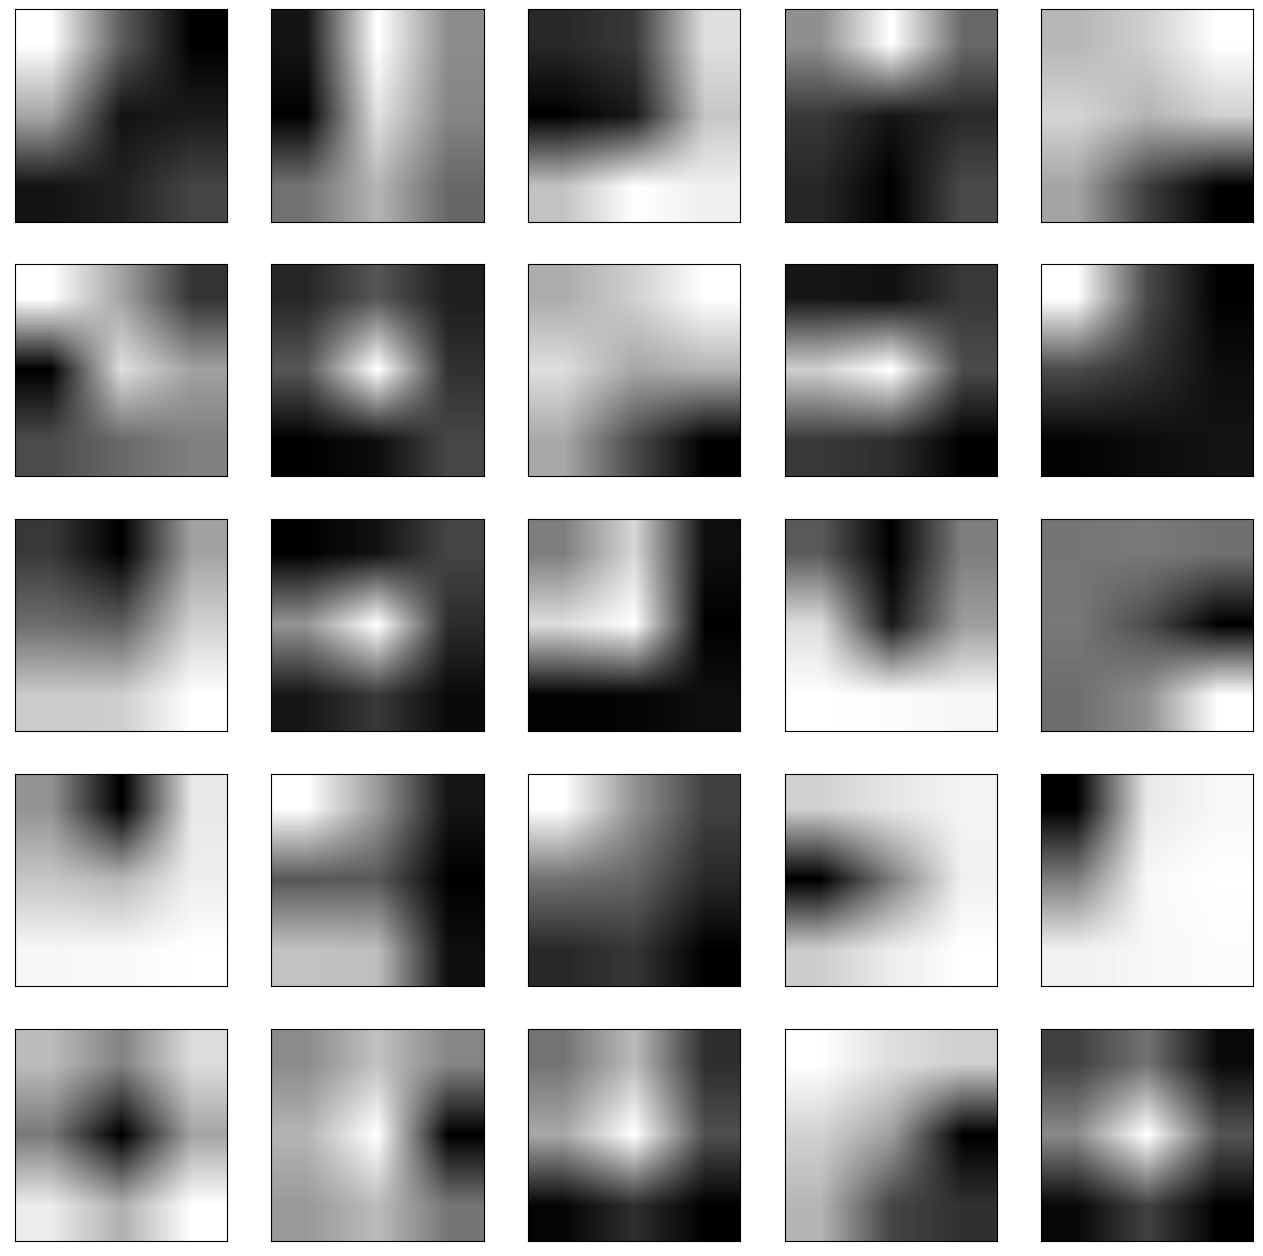

In [17]:
tools.vis.visualize_filters(model.encoder, 'blocks.0.0.conv_dw.weight', max_filters = 25)

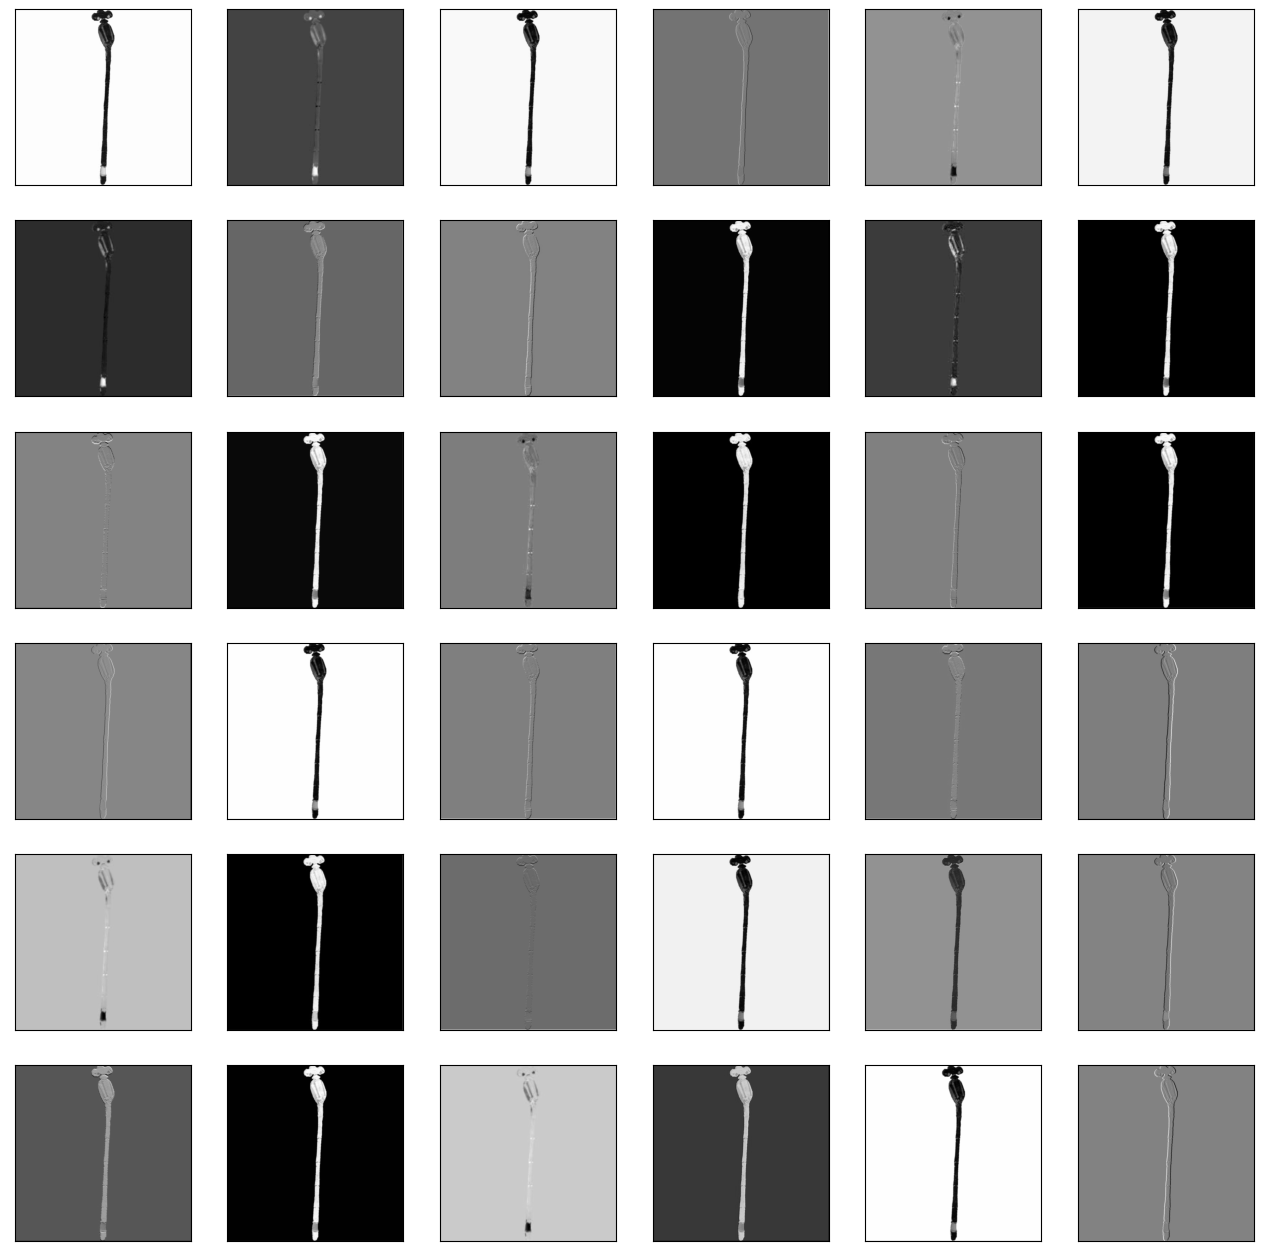

In [18]:
tools.vis.visualize_activations(model.encoder, model.encoder[0], img, device='cpu')

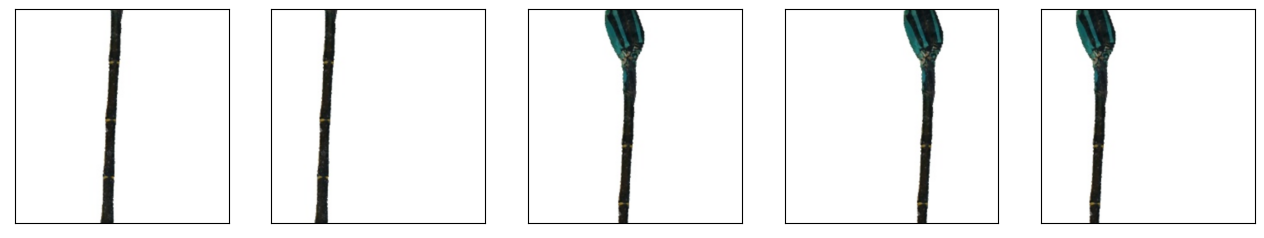

In [19]:
tools.vis.maximally_activated_patches(model.encoder, img, patch_size=512, device='cpu')

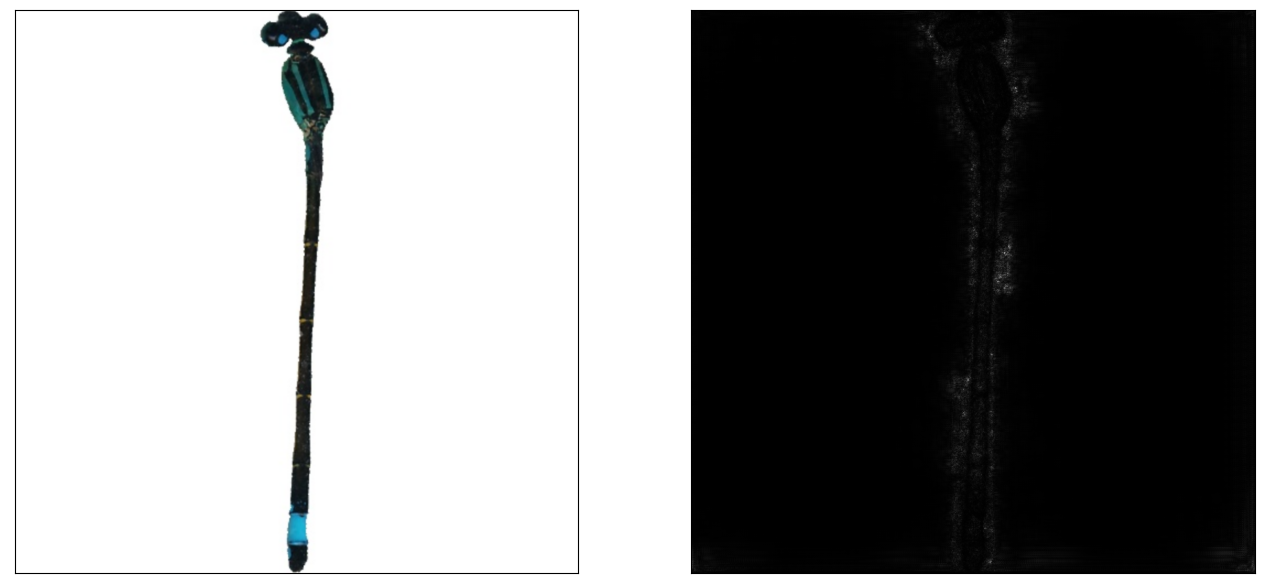

In [24]:
tools.vis.saliency_map(model.encoder,img)

Epoch: 50 Confidence score for class 0: 0.0
Epoch: 100 Confidence score for class 0: 0.0
Epoch: 150 Confidence score for class 0: 0.0
Epoch: 200 Confidence score for class 0: 0.0
Epoch: 250 Confidence score for class 0: 0.0
Epoch: 300 Confidence score for class 0: 0.0
Epoch: 350 Confidence score for class 0: 0.0
Epoch: 400 Confidence score for class 0: 0.0
Epoch: 450 Confidence score for class 0: 0.0
Epoch: 500 Confidence score for class 0: 1.0
Reached 1.0 confidence score in epoch 500. Stopping early.


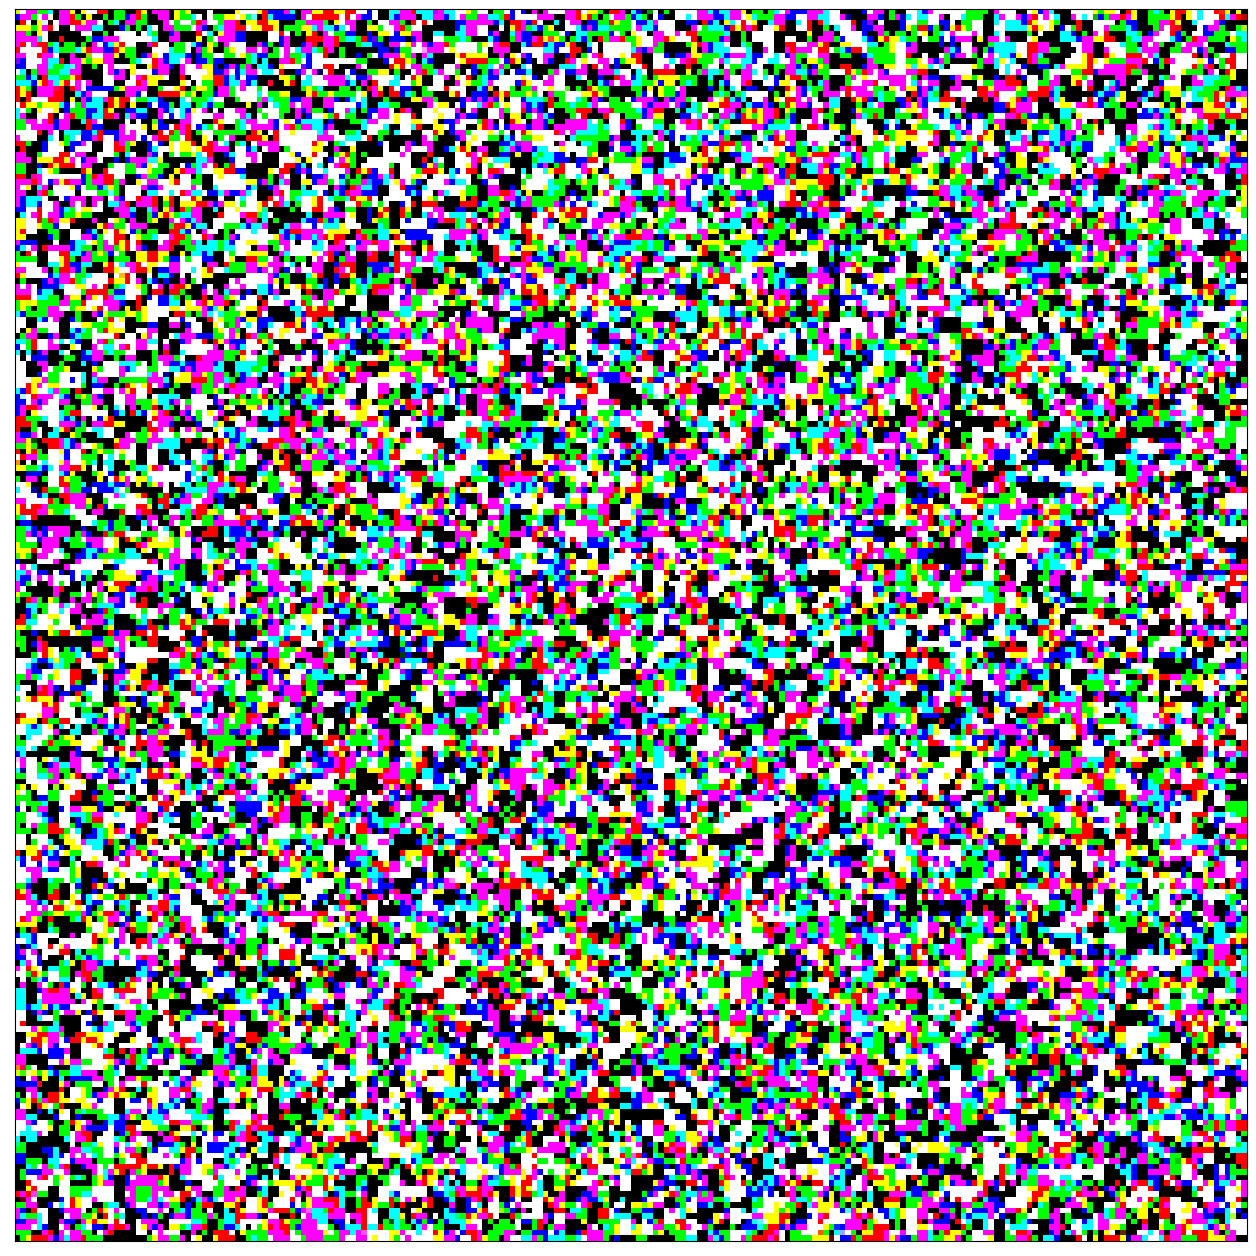

In [25]:
synthetic_image = tools.vis.generate_image(model = model.encoder, target_class = 0, epochs = 500, min_prob = 0.9, lr = 1, weight_decay = 5e-2, 
                        step_size = 100, gamma = 0.9)

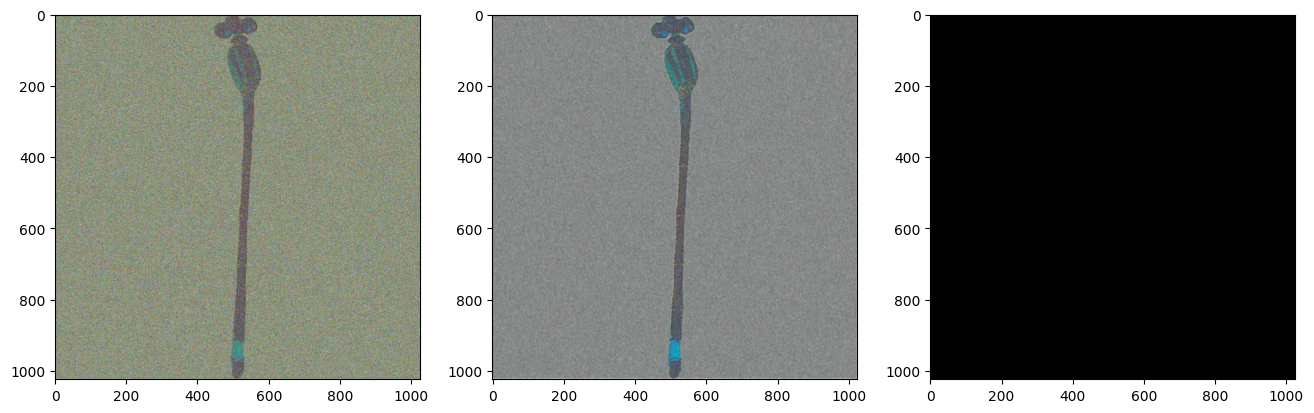

In [26]:
modules = [model.encoder[0],model.encoder[1], model.encoder[2]]
tools.vis.feature_inversion(model.encoder, modules,  img, 100, 5e-5)

tf_efficientnet_b4


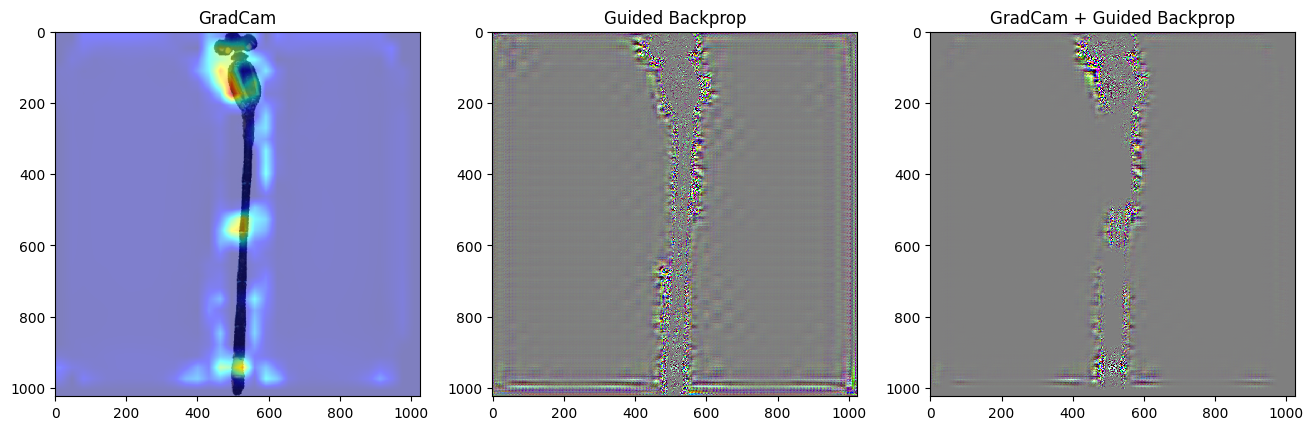

In [27]:
model = tools.utils.build_model(backbone, second_stage='second', num_classes=4, ckpt_pretrained=ckpt_pretrained).cuda()

tools.vis.grad_cam(model, model.encoder,img,target_layer=["4"], target_category= None)

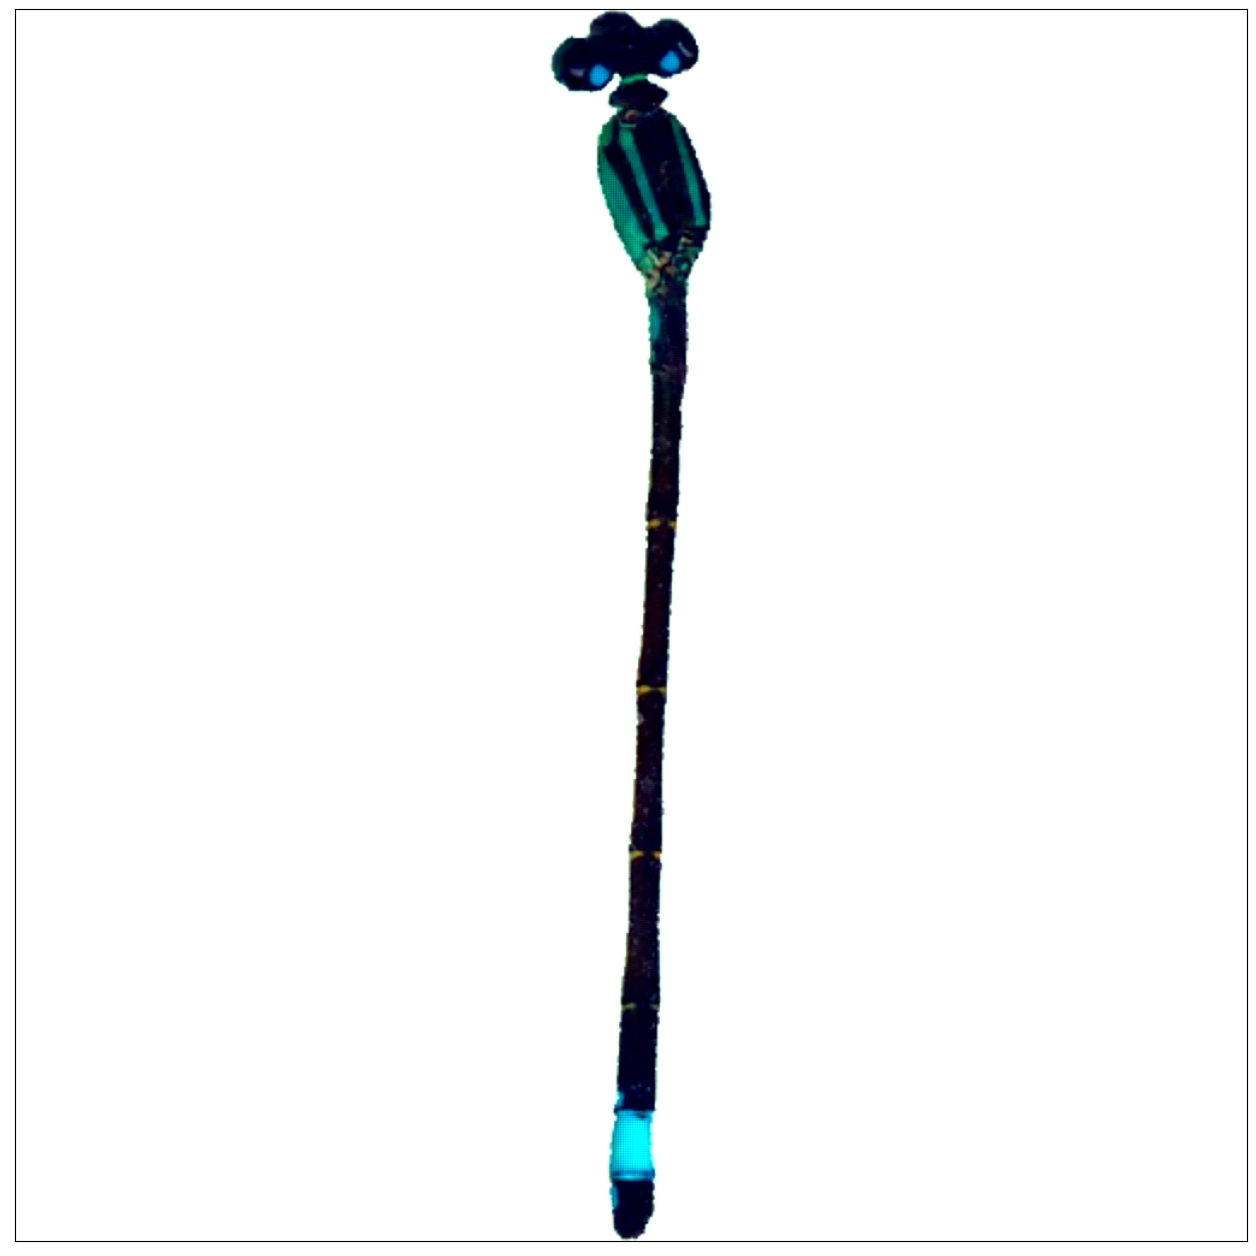

In [28]:
dream = tools.vis.deep_dream(model = model, module = model.encoder[0], img= img, epochs = 100, lr = 2)